### Using Age, Blood Pressure, Heart Rate, Cholesterol, and Fluoroscopy to Predict Heart disease

### Introduction:

Heart disease (HD) encompasses heart conditions that affect heart function (Heart and Stroke Foundation of Canada, 2023). It is the second leading cause of death in Canada (Government of Canada, 2022). HD progression can be slowed through a healthy lifestyle if diagnosed early (Heart and Stroke Foundation of Canada, 2023).

**In our data set, the columns are:**

- Patient’s age (years)

- Patient’s sex

- Chest pain type (typical angina, atypical angina, non-anginal pain, asymptomatic)

- Resting blood pressure (mmHg)

- Cholesterol levels (mg/dL)

- Fasting blood sugar (above/below 120mg/dL)

- Resting electrocardiographic results (normal, ST-T wave abnormality, ventricular hypertrophy)

- Maximum heart rate (bpm)

- Exercise-induced angina occurred

- Depression of the ST segment on an ECG from exercise

- Slope of the peak ST segment from exercise (upslope, flat, downslope)

- Number of major arteries coloured by fluoroscopy (0-3)

- Thalassemia status (normal, fixed defect, reversible defect)

- Heart disease diagnosis (called hd for short)


Research question: **based on a patient’s characteristics, what is their likely HD diagnosis?**

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

Warning message in file(filename, "r", encoding = encoding):
“cannot open file 'tests.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [4]:
set.seed(50)
heart_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE) |>
    rename("age"= X1, "sex" = X2, "chest_pain" = X3, "trestbps" = X4, "chol" = X5, "fasting_bs" = X6, "restecg" = X7, "max_heart_rate" = X8, "exang" = X9, "old_peak" = X10, "peak_slope" = X11, "ca" = X12, "thal" = X13, "predicted" = X14) |>
    mutate(sex = recode(sex, "1" = "male", "0" = "female")) |>
    mutate(chest_pain = recode(chest_pain, "1" = "typical_angina", "2" = "atypical_angina", "3" = "non_anginal_pain", "4" = "asymptomatic")) |>
    mutate(restbps = as.integer(trestbps)) |>
    mutate(chol = as.integer(chol)) |>
    mutate(fasting_bs = recode(fasting_bs, "1" = "over_120", "0" = "under_120")) |>
    mutate(restecg = recode(restecg, "0" = "normal", "1" = "abnormal", "2" = "hypertrophy")) |>
    mutate(max_heart_rate = as.integer(max_heart_rate)) |>
    mutate(old_peak = as.numeric(old_peak)) |>
    mutate(fluoro = as.integer(ca)) |>
    mutate(exang = recode(exang, "0" = "no", "1" = "yes")) |>
    mutate(peak_slope = as.integer(peak_slope)) |>
    mutate(thal = recode(thal, "3.0" = "normal", "6.0" = "fixed_defect", "7.0" = "reversable_defect")) |>
    mutate(predicted = as.factor(predicted)) |>
    mutate(predicted = recode(predicted, "0" = "no_hd", "1" = "hd", "2" = "hd", "3" = "hd", "4" = "hd"))

heart_data_select <- heart_data |> select(age,restbps, chol, max_heart_rate, fluoro, predicted)
  
heart_data_select

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,no_hd
67,160,286,108,3,hd
67,120,229,129,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
57,130,131,115,1,hd
57,130,236,174,1,hd
38,138,175,173,NA,no_hd


### Tablature Analysis: 

To begin our exploratory data analysis, we began by counting the quantity of NA values that the dataset contains. 

In [5]:
heart_data_select |> summarise(Num_Of_NA = sum(is.na(heart_data_select)))

Num_Of_NA
<int>
4


As we can see there are NA entries in our data.
Let us remove them.

In [6]:
heart_data_select <- heart_data_select |>
    na.omit()
heart_data_select

age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
63,145,233,150,0,no_hd
67,160,286,108,3,hd
67,120,229,129,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
68,144,193,141,2,hd
57,130,131,115,1,hd
57,130,236,174,1,hd


In [7]:
heart_split <- initial_split(heart_data_select, prop = 0.75, strata = predicted)
heart_train <- training(heart_split)
heart_test <- testing(heart_split)

heart_train

age,restbps,chol,max_heart_rate,fluoro,predicted
<dbl>,<int>,<int>,<int>,<int>,<fct>
67,160,286,108,3,hd
67,120,229,129,2,hd
62,140,268,160,2,hd
⋮,⋮,⋮,⋮,⋮,⋮
56,130,221,163,0,no_hd
55,132,342,166,0,no_hd
41,120,157,182,0,no_hd


Let us see how many total observations we have:

In [8]:
nrow(heart_train)

[1] 223

Now let us see how many of these have heart disease and how many do not.

In [9]:
heart_train |> count(predicted)

predicted,n
<fct>,<int>
no_hd,120
hd,103


This table displays the most affected category/mean for each variable which are most prone to getting heart disease in our dataset.

In [10]:
heart_train |> group_by(predicted) |>
    summarise(Mean_Affected_Age = mean(age),
          Average_Resting_BPS = mean(restbps),
          Average_Chol = mean(chol),
          Avg_Maximum_Heart_rate_Recorded = mean(max_heart_rate),
        Avg_fluoroscopy_count = mean(fluoro))

predicted,Mean_Affected_Age,Average_Resting_BPS,Average_Chol,Avg_Maximum_Heart_rate_Recorded,Avg_fluoroscopy_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
no_hd,52.30000,128.1417,244.1000,159.2833,0.350000
hd,56.53398,135.5825,256.6796,138.4563,1.165049


This table shows higher average age, resting blood pressure, cholesterol, and fluoroscopy highlights; but lower average heart rate for those with HD than without.

### Visualization Analysis:

To explore our training data, we began by plotting proportion of HD diagnoses against age.

`summarise()` has grouped output by 'age'. You can override using the `.groups`
argument.


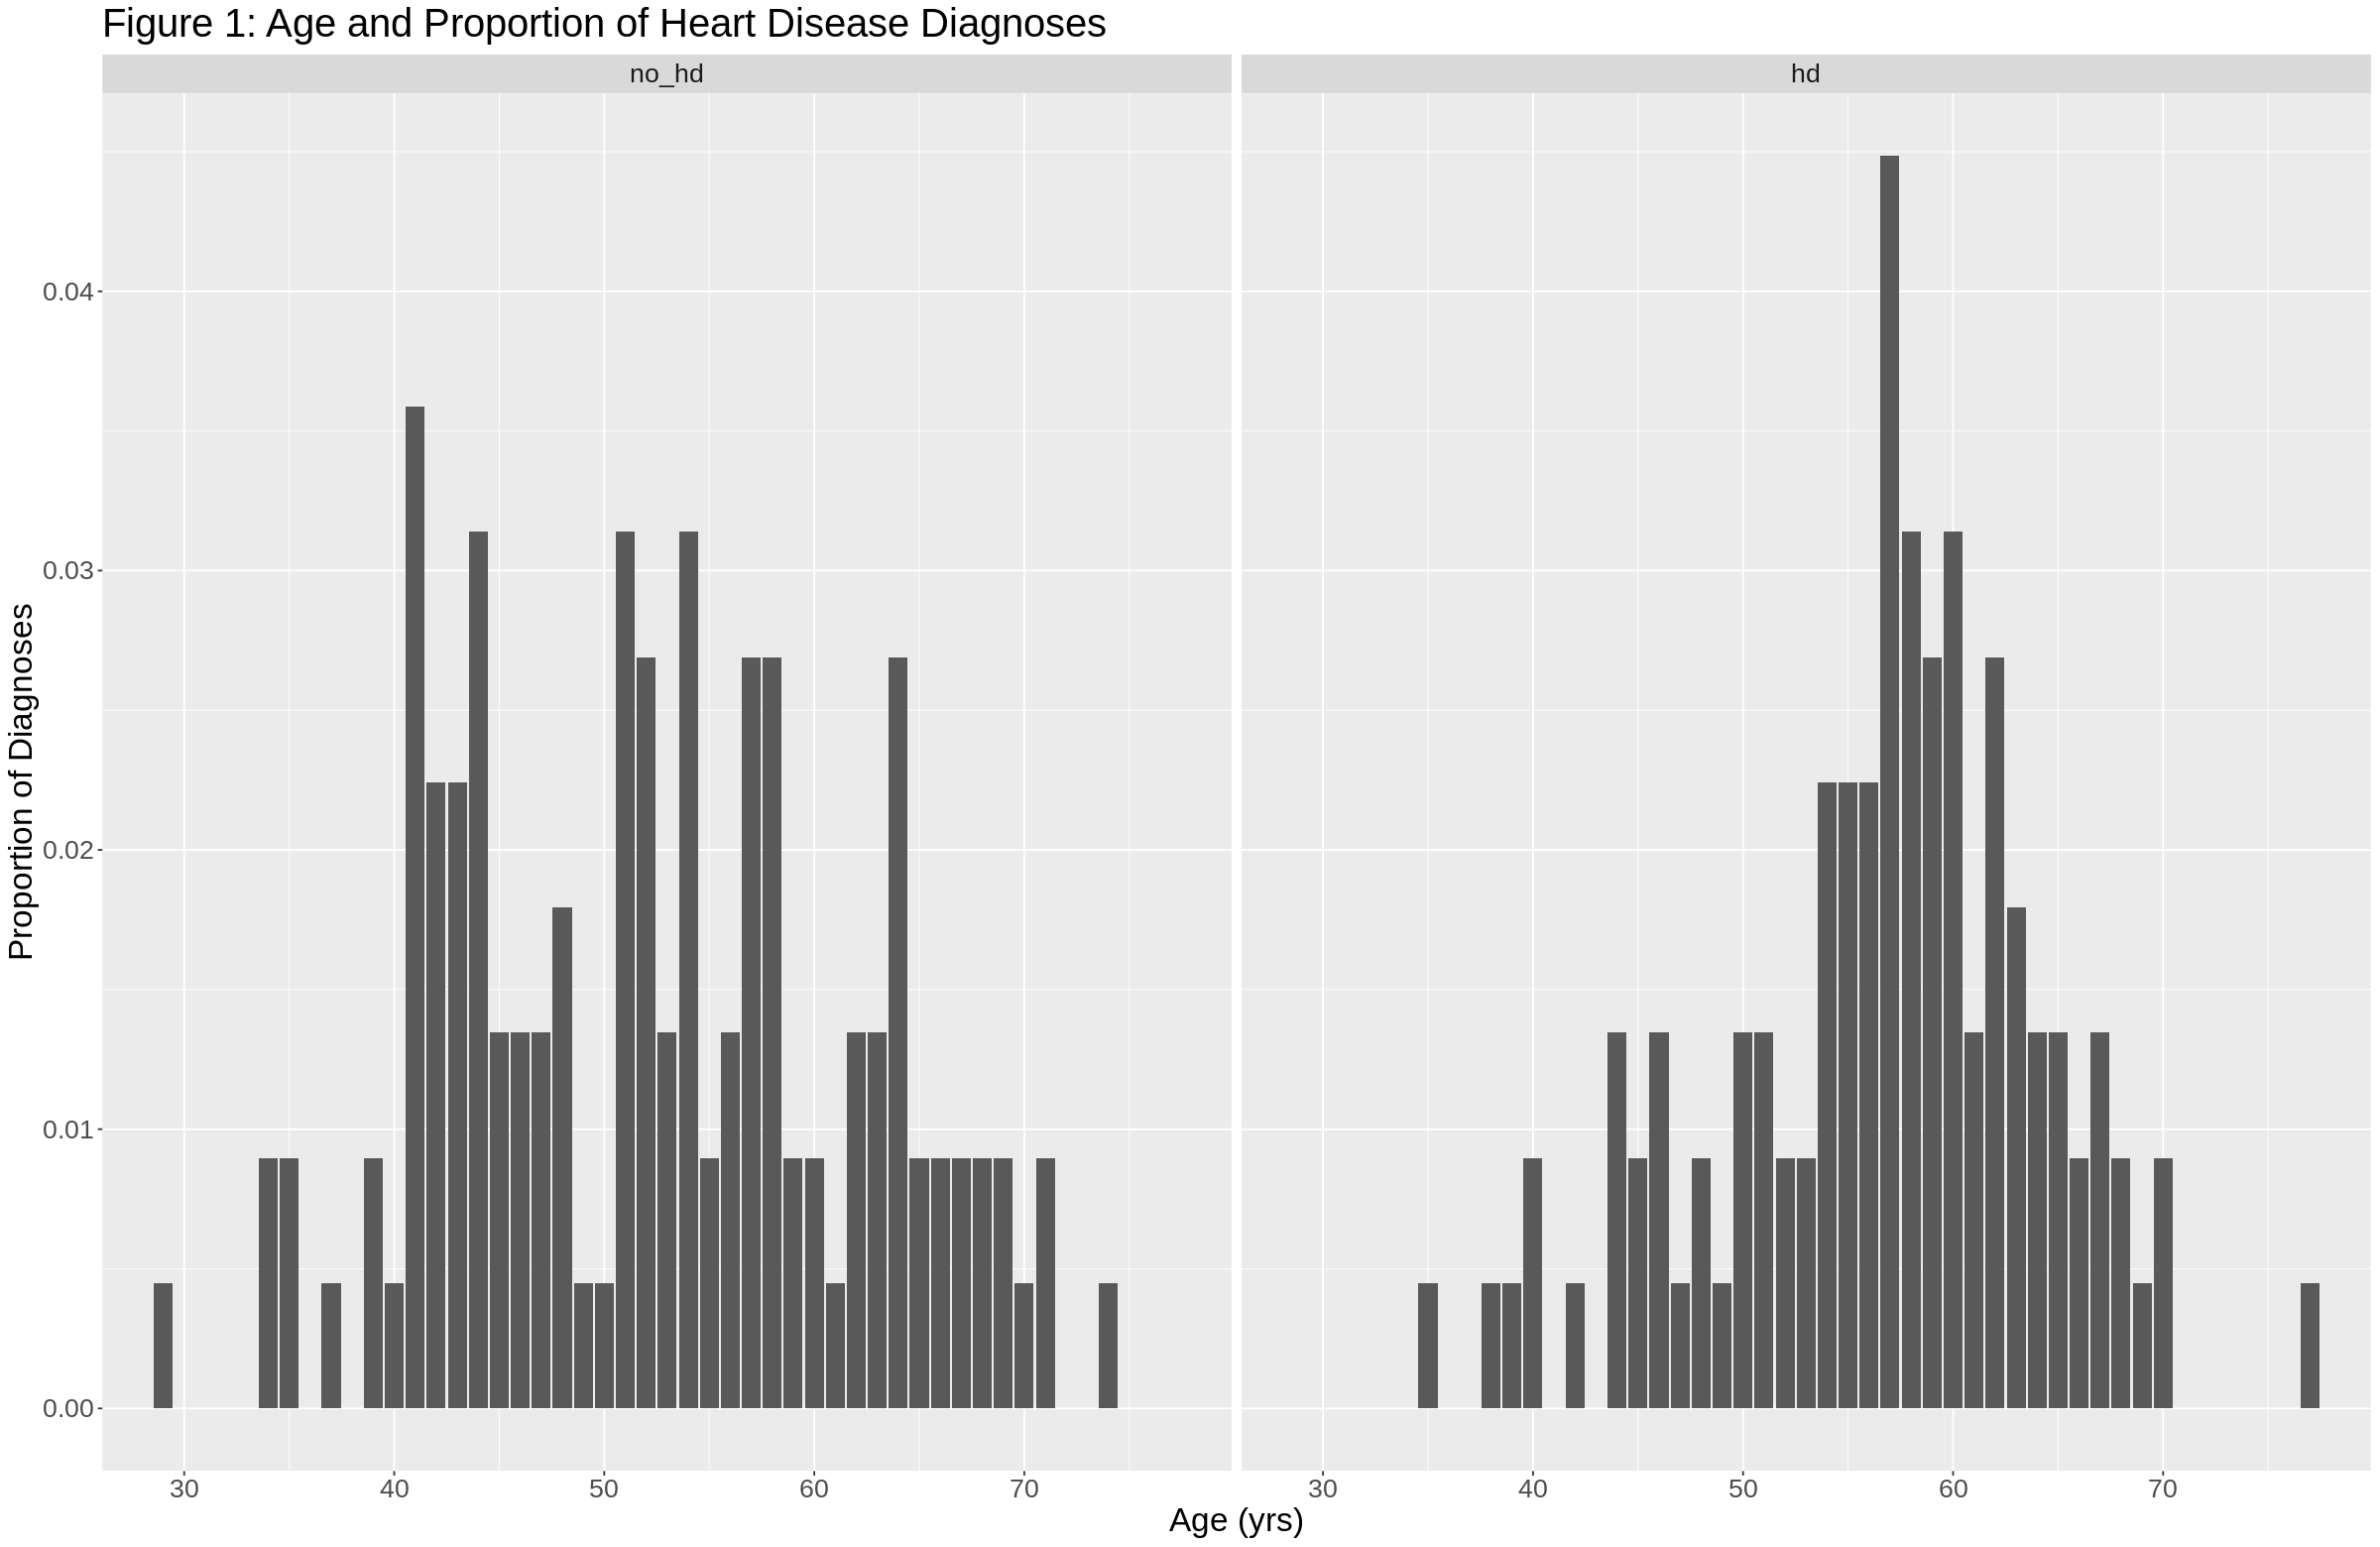

In [11]:
options(repr.plot.width = 20, repr.plot.height = 13) 
total_rows <- nrow(heart_train)
hd_age_count <- heart_train |>
    group_by(age, predicted) |>
    summarize(count = n()/total_rows)

hd_age_plot <- hd_age_count |>
    ggplot(aes(x = age, y = count)) +
    geom_bar(stat = "identity") +
    labs(x = "Age (yrs)", y = "Proportion of Diagnoses") +
    scale_fill_discrete(labels = c("No Heart Disease  Present", "Heart Disease Present")) +
    ggtitle("Figure 1: Age and Proportion of Heart Disease Diagnoses") + 
    facet_grid(cols = vars(predicted)) +
    theme(text = element_text(size = 20))

hd_age_plot

A significant proportion of patients with HD are around 60, but the age is more distributed without HD. 

Next, the cholesterol levels count should be observed as high cholesterol levels are linked to heart disease.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



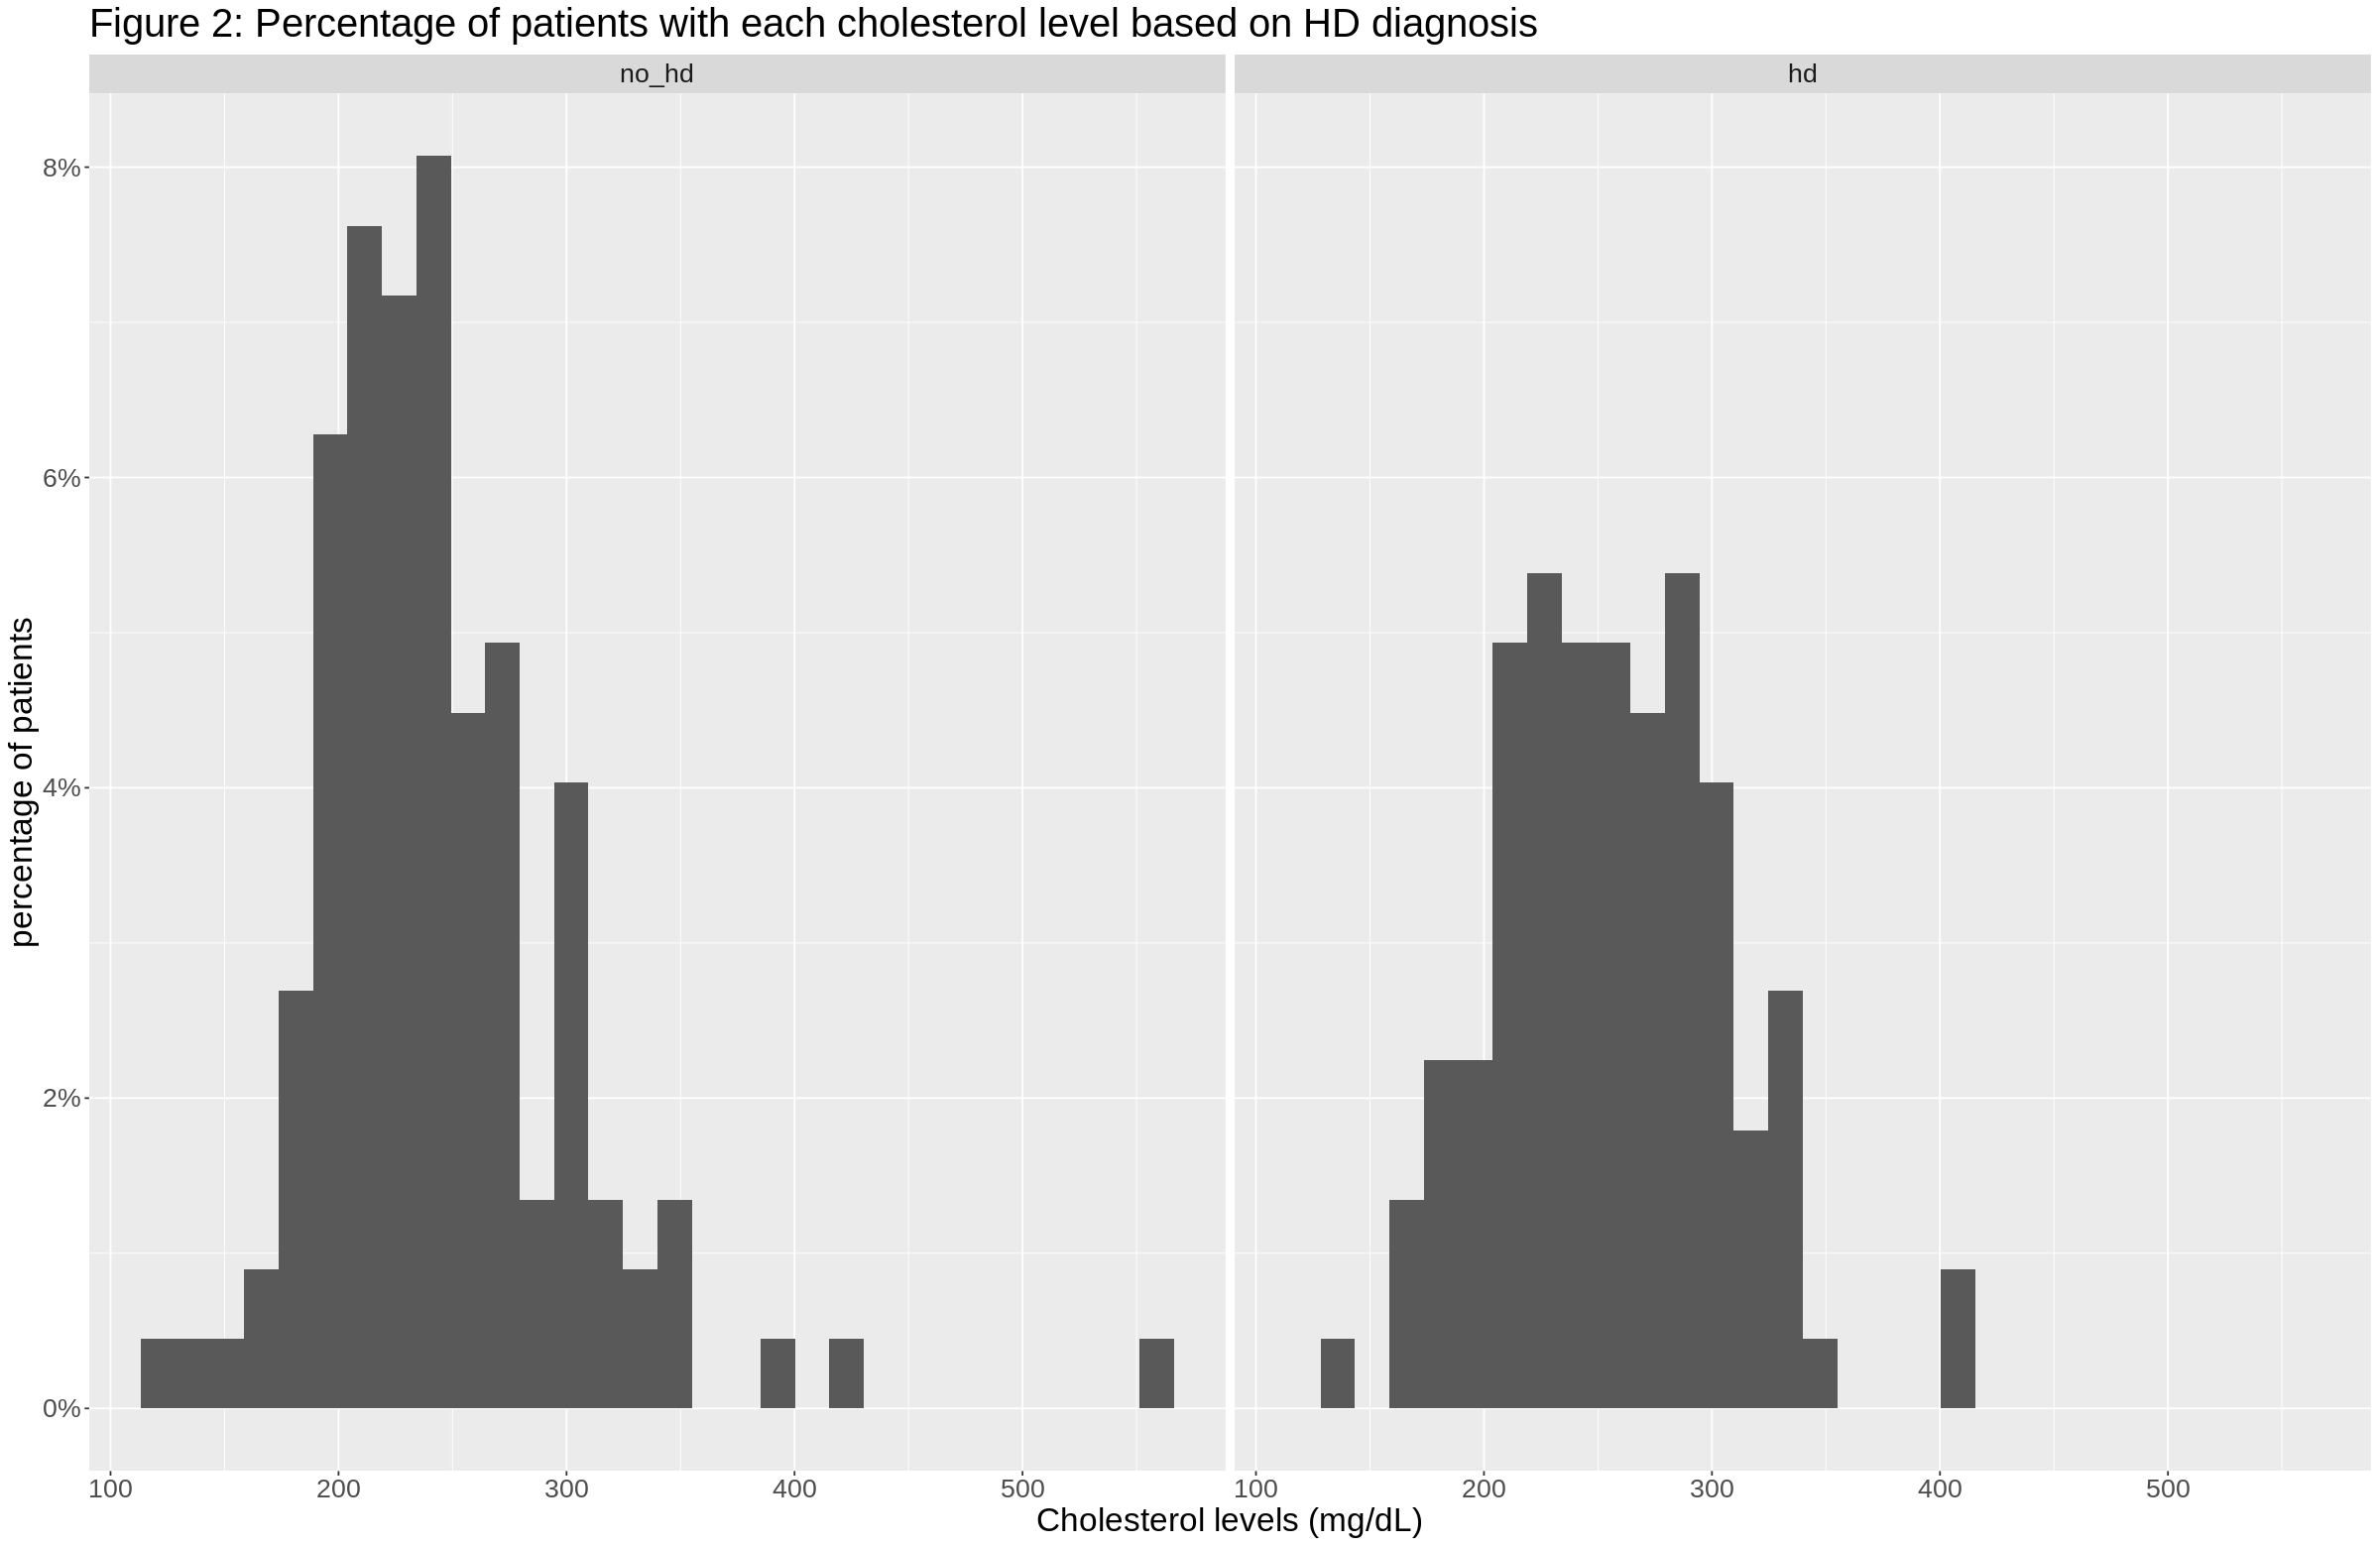

In [12]:
chol_plot<- heart_train|>
    ggplot(aes(x=chol))+
    geom_histogram(aes(y = (..count..)/sum(..count..))) +
  scale_y_continuous(labels=percent)+
    facet_grid(cols = vars(predicted))+
    labs(x = "Cholesterol levels (mg/dL)", y = "percentage of patients") +
    scale_fill_discrete(labels = c("No Heart Disease  Present", "Heart Disease Present")) +
    ggtitle("Figure 2: Percentage of patients with each cholesterol level based on HD diagnosis") + 
    theme(text = element_text(size = 20))
    
chol_plot

Patients with HD are shown to have a median cholesterol level slightly higher than those without.

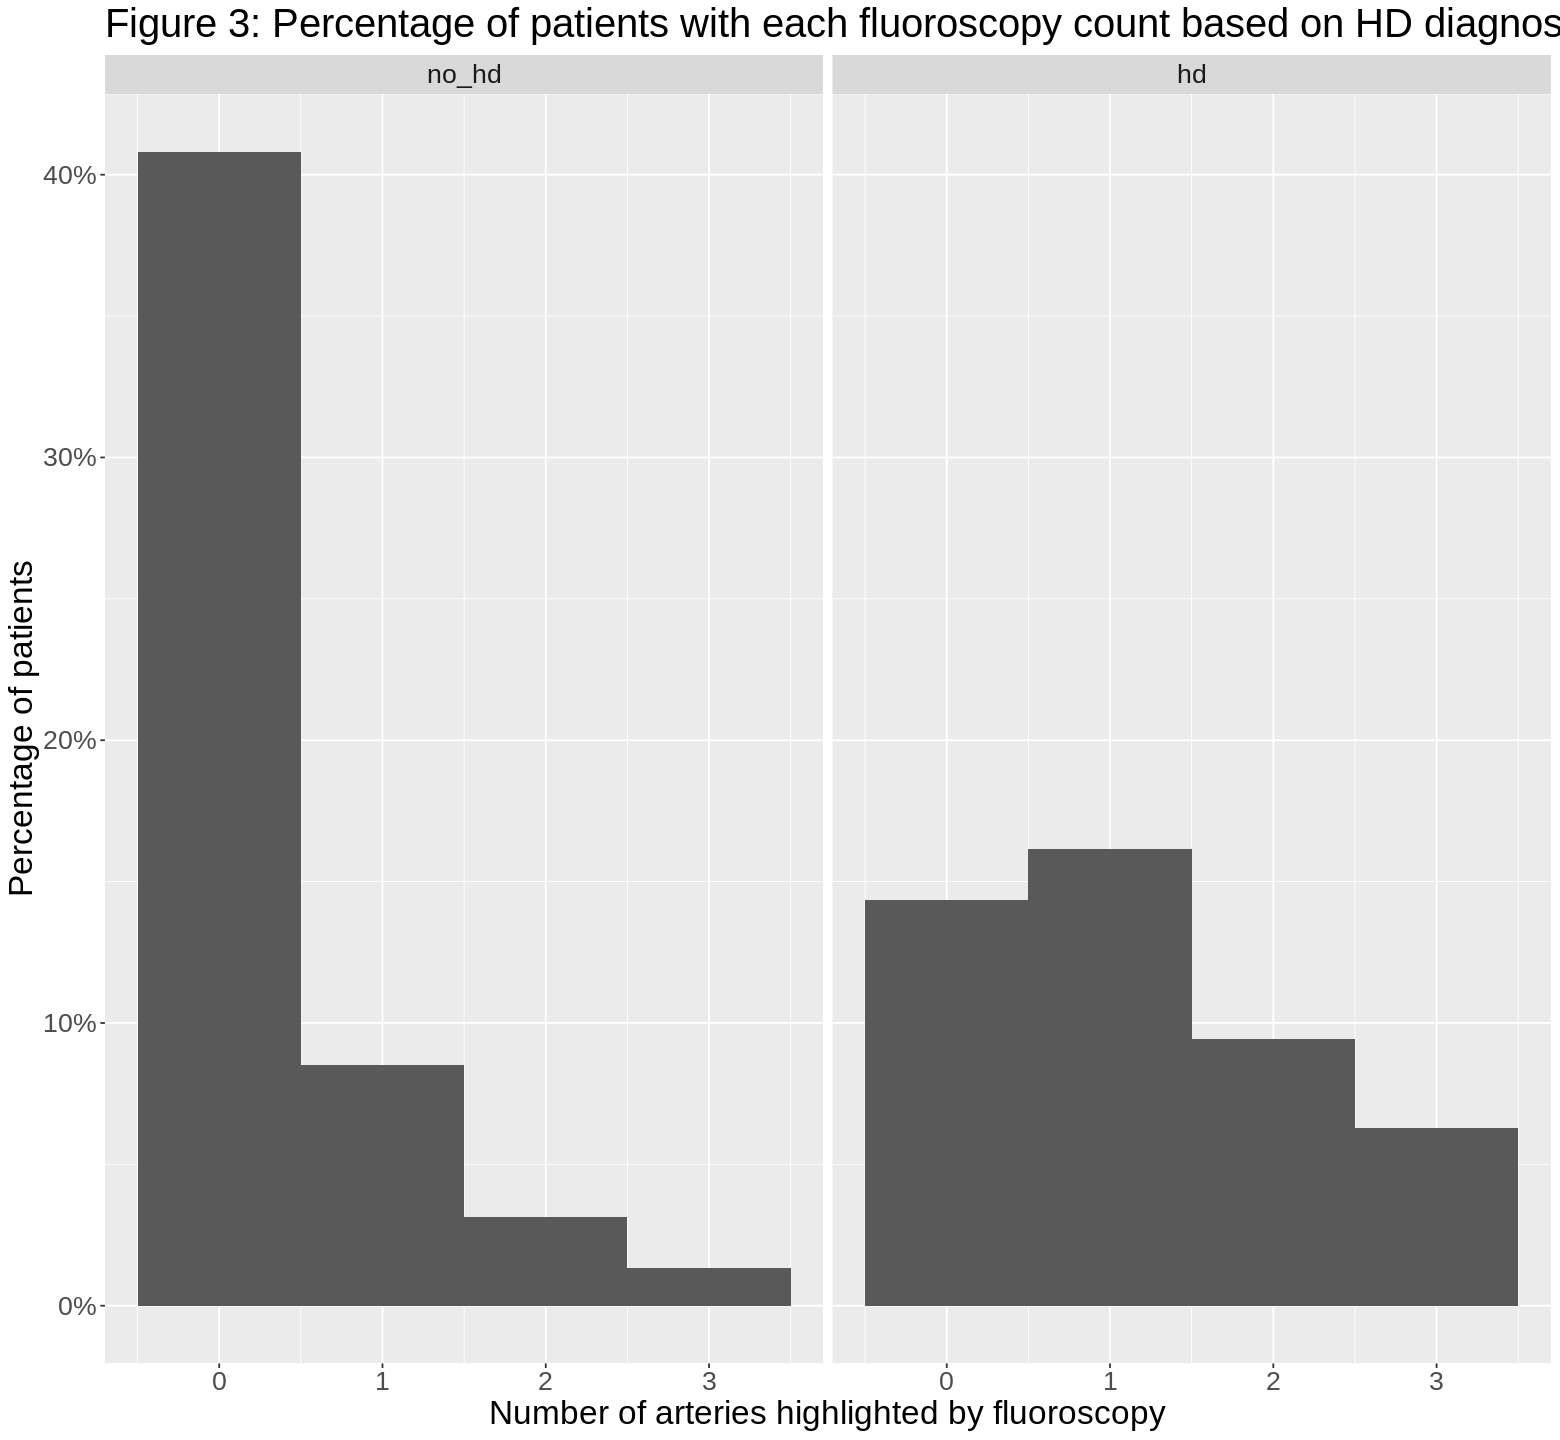

In [13]:
options(repr.plot.width = 13, repr.plot.height = 12)
fluoro_plot<- heart_train|>
    ggplot(aes(x=fluoro))+
    geom_histogram(bins = 4, (aes(y = (..count..)/sum(..count..)))) +
  scale_y_continuous(labels=percent)+
    facet_grid(cols = vars(predicted))+
    labs(x = "Number of arteries highlighted by fluoroscopy", y = "Percentage of patients") +
    scale_fill_discrete(labels = c("No Heart Disease  Present", "Heart Disease Present")) +
    ggtitle("Figure 3: Percentage of patients with each fluoroscopy count based on HD diagnosis") + 
    theme(text = element_text(size = 20))

fluoro_plot

Patients without HD have fewer arteries highlighted by fluoroscopy as they function normaly, contrasting to patients with HD.

### Methods:




We begin by splitting the dataset into training and testing datasets. The analysis will be done using K-nearest neighbor classification using predictor variables variables including age, resting blood pressure, exercising heart rate, cholesterol level, and fluoroscopy.

We picked the age variable because as age increases, a person’s risk of heart disease may increase (National Institutes of Health, 2018). Studies show that high blood pressure is a common symptom of heart disease (American Heart Association, 2022). Similarly, same correlations can be seen with heart rate (Perret-Guillaume et al., 2009) and cholesterol level (Heart and Stroke Foundation of Canada, 2023). Fluoroscopy is used to see the blood flow in arteries, which is an indicator of artery blockage that can help doctors diagnose heart disease (Johns Hopkins Medicine, 2019).

The results will be shown using graphs depicting correlation between physical properties and the presence or absence of heart disease. 


### Expected outcomes and significance:

We expect to produce a prediction model for the heart disease diagnosis based on age, cholesterol, blood pressure, fluoroscopy and heart rate. It could allow for a preliminary suggestion towards the patient's HD status which could open a door for classification to be used as a preliminary tool for diagnoses of other diseases.

**References**

American Heart Association. (2022, March 4). Health threats from high blood pressure. www.heart.org. Retrieved March 2, 2023, from https://www.heart.org/en/health-topics/high-blood-pressure/health-threats-from-high-blood-pressure#:~:text=Angina%20%E2%80%94%20Over%20time%2C%20high%20blood,head%2C%20causing%20pain%20or%20fatigue.

Canada, P. H. A. of. (2022, July 28). Government of Canada. Canada.ca. Retrieved March 2, 2023, from https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html 

Heart and Stroke Foundation of Canada. (2023). Managing cholesterol. Heart and Stroke Foundation of Canada. Retrieved March 2, 2023, from https://www.heartandstroke.ca/heart-disease/risk-and-prevention/condition-risk-factors/managing-cholesterol 

Heart and Stroke Foundation of Canada. (2023). Types of heart disease. Heart and Stroke Foundation of Canada. Retrieved March 2, 2023, from https://www.heartandstroke.ca/heart-disease/what-is-heart-disease/types-of-heart-disease 


Johns Hopkins Medicine. (2019, August 14). Fluoroscopy procedure. Fluoroscopy Procedure | Johns Hopkins Medicine. Retrieved March 2, 2023, from https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/fluoroscopy-procedure#:~:text=Fluoroscopy%20is%20a%20study%20of,can%20be%20seen%20in%20detail 

National Institutes of Health. (2018). Heart health and aging. National Institute on Aging. Retrieved March 2, 2023, from https://www.nia.nih.gov/health/heart-health-and-aging#changes 

NHS. (2020). Coronary heart disease - Diagnosis - NHS. NHS choices. Retrieved March 2, 2023, from https://www.nhs.uk/conditions/coronary-heart-disease/diagnosis/ 

Perret-Guillaume, C., Joly, L., & Benetos, A. (2009). Heart rate as a risk factor for cardiovascular disease. Progress in Cardiovascular Diseases, 52(1), 6–10. https://doi.org/10.1016/j.pcad.2009.05.003 